In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread
import cv2
import pickle

In [ ]:
! pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00


In [ ]:
import pydicom
from PIL import Image

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Data_PS3/Data_tabular/dataset_image.csv")

In [ ]:
train_dft = pd.read_csv("/content/drive/MyDrive/Data_PS3/Data_tabular/dataset_image_complet.csv")

In [ ]:
intersection_df=pd.merge(train_df, train_dft, how='inner')
intersection_df.head()

,Unnamed: 0,anon_filename,rad_decision,viewposition
0,21455,01929_20990909_L_CC_4.dcm,0.0,CC
1,63483,06130_20990909_L_MLO_5.dcm,0.0,MLO
2,55224,05215_20990909_R_MLO_3.dcm,0.0,MLO
3,9273,00844_20990909_R_CC_4.dcm,0.0,CC
4,9536,00867_20990909_R_CC_3.dcm,0.0,CC


In [ ]:
train_df.head()

,Unnamed: 0,anon_filename,rad_decision
0,21455,01929_20990909_L_CC_4.dcm,0.0
1,63483,06130_20990909_L_MLO_5.dcm,0.0
2,55224,05215_20990909_R_MLO_3.dcm,0.0
3,9273,00844_20990909_R_CC_4.dcm,0.0
4,9536,00867_20990909_R_CC_3.dcm,0.0


In [ ]:
intersection_df.viewposition.value_counts()

MLO    5105
CC     4895
Name: viewposition, dtype: int64

In [ ]:
viewpos=list(intersection_df.viewposition)
len(viewpos)

10000

In [ ]:
train_df['rad_decision'].value_counts()

0.0    5000
1.0    5000
Name: rad_decision, dtype: int64

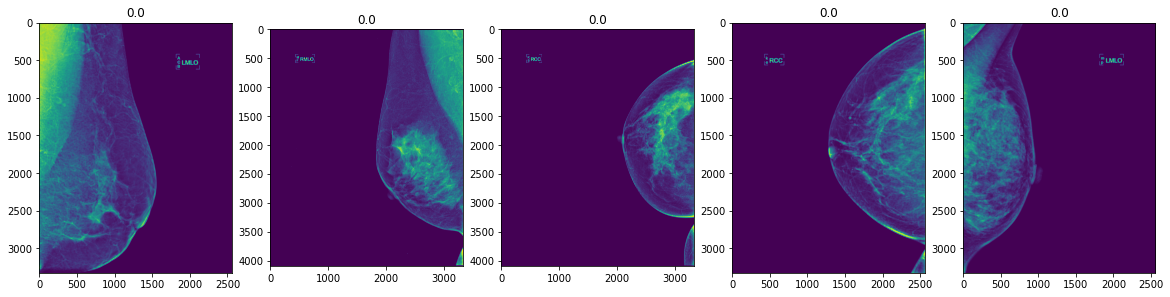

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Data/'

img_name= list(train_df.anon_filename)

img_class=list(train_df.rad_decision)

sel_img=[]
class_=[]
for i in [1,2,3,4,5]:
  sel_img.append(img_name[i])
  class_.append(img_class[i])

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(sel_img, class_)]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))

#show the images and label them
for ii, c_ax in enumerate(m_axs):
    img=imread(os.path.join(img_path,images[ii][0]))
    c_ax.imshow(img)
    c_ax.set_title(images[ii][1])

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Data/'

dest_path = "/content/drive/MyDrive/Data_PS3/Image_original/"

img_name= list(train_df.anon_filename)

for img in img_name[:10]:
  # Load the DICOM image using pydicom
  image_path = img_path + img

  ds = pydicom.dcmread(image_path)

  # Convert the DICOM image to a NumPy array
  image = ds.pixel_array

  # Convert the NumPy array to a PIL image
  pil_image = Image.fromarray(image)

  img= img.replace("dcm", "png")

  dest_file = dest_path + img

  # Save the PIL image in the PNG format
  pil_image.save(dest_file)

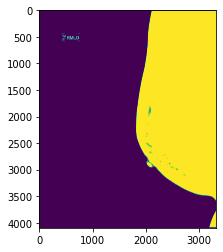

In [ ]:
if image.dtype != "uint8":
    # convert the image to 8-bit unsigned integers
    image = cv2.convertScaleAbs(image)
plt.imshow(image)

In [ ]:
img_name[4]

'00867_20990909_R_CC_3.dcm'

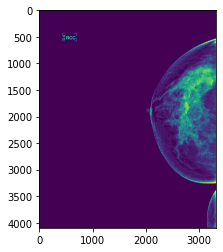

In [ ]:
imgp=cv2.imread("/content/drive/MyDrive/Data_PS3/Image_original/00844_20990909_R_CC_4.png",0)
plt.imshow(imgp)

### median filtering

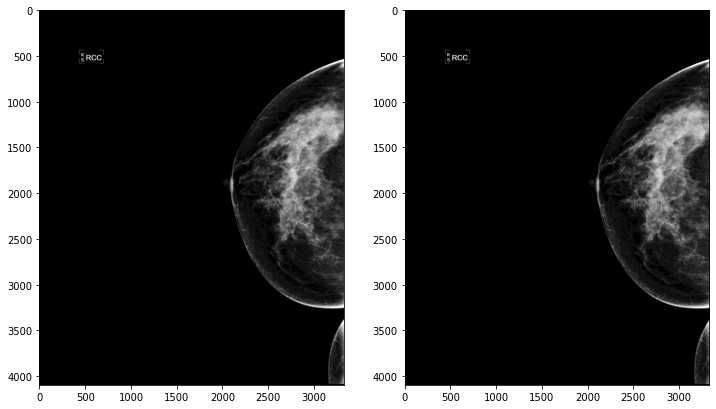

In [ ]:
mammo_med_blurred = cv2.medianBlur(imgp, 3)
#res = np.hstack((image, mammo_med_blurred))
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(mammo_med_blurred, cmap='gray')


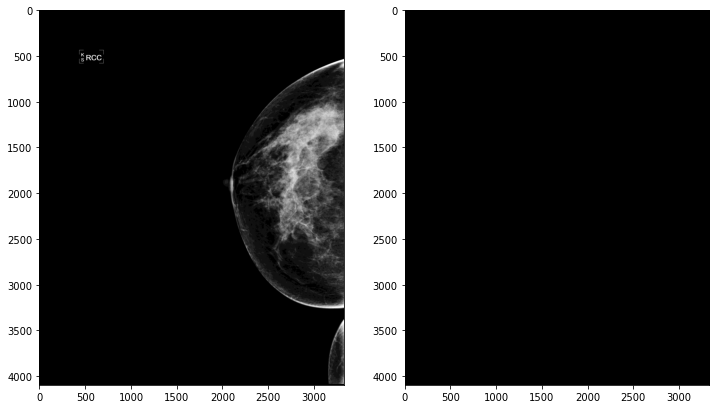

In [ ]:
global_threshold = 18
#mammo_med_blurred_col = cv2.cvtColor(mammo_med_blurred, cv2.COLOR_GRAY2BGR)
#mammo_med_blurred_u8 = cv2.convertScaleAbs(mammo_med_blurred, alpha=u16u8_alpha)
_, mammo_binary = cv2.threshold(mammo_med_blurred, global_threshold,
                                maxval=255, type=cv2.THRESH_BINARY)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_binary, cmap='gray')

#### Artifacts suppression

In [ ]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False,
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin(2D array): 2D numpy array of binary image.
        lab_val([int]): integer value used for the label of the largest
                        object. Default is 255.
        fill_holes([boolean]): whether fill the holes inside the largest
                               object or not. Default is false.
        smooth_boundary([boolean]): whether smooth the boundary of the
                                    largest object using morphological
                                    opening or not. Default is false.
        kernel_size([int]): the size of the kernel used for morphological
                            operation.
    '''
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)

    return largest_mask

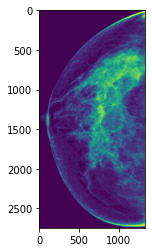

In [ ]:
imgC=cv2.imread("/content/drive/MyDrive/Data_PS3/Image_png/00844_20990909_R_CC_4.png",0)
plt.imshow(imgC)

In [ ]:
mammo_med_blurred1 = cv2.medianBlur(imgC, 3)

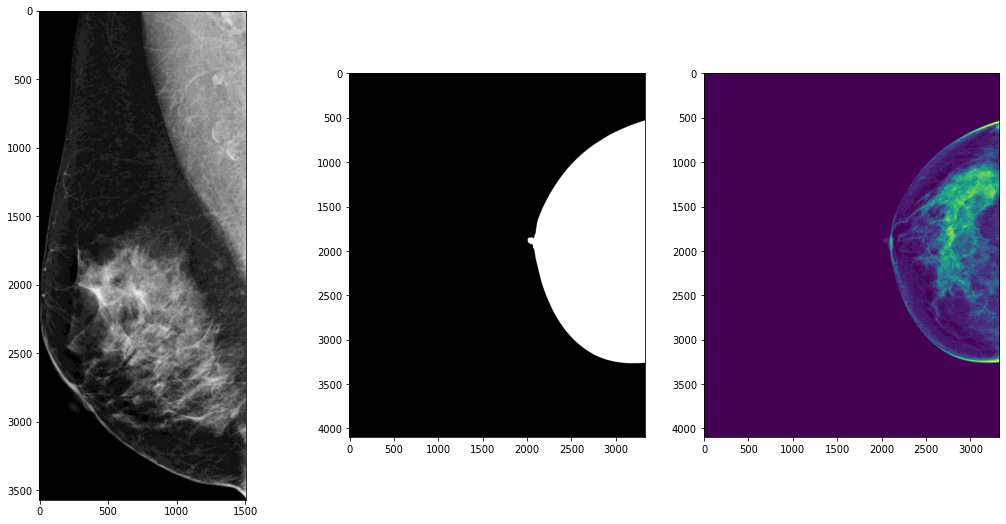

In [ ]:
# #u16_maxval = gen_maxval_mask(mammo_med_blurred.dtype)
mammo_breast_mask = select_largest_obj(mammo_med_blurred, lab_val=255,
                                       fill_holes=True,
                                       smooth_boundary=True, kernel_size=15)  # <<= para to tune!


mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)
fig,axes = plt.subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_med_blurred1, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr)#, cmap='gray')

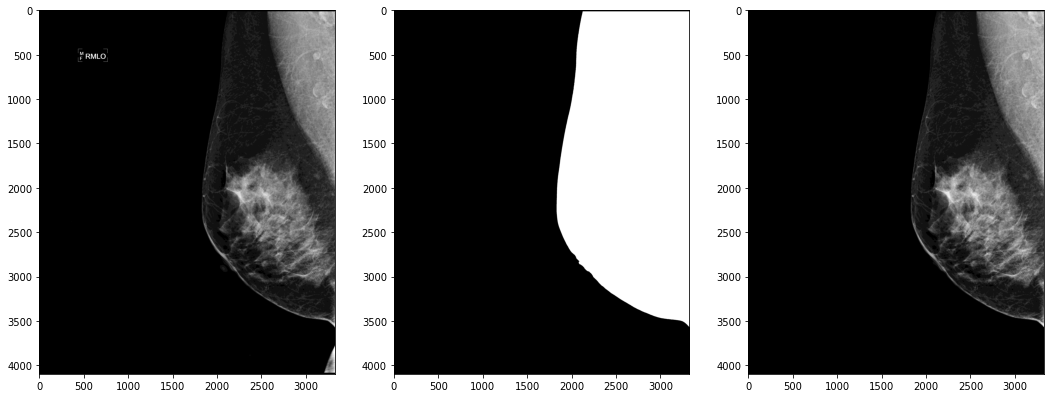

In [ ]:
fig,axes = plt.subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr, cmap='gray')

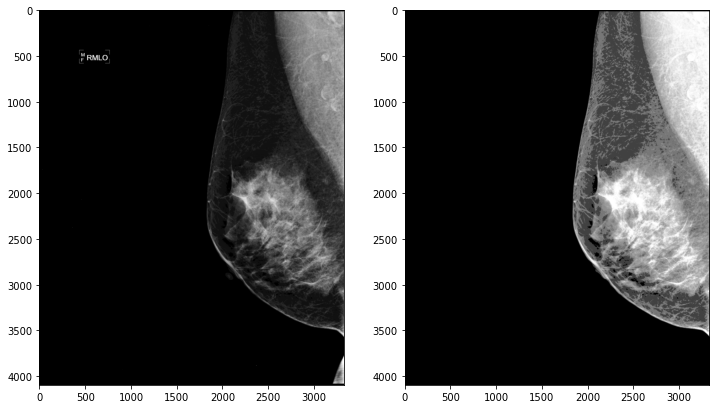

In [ ]:
mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(mammo_breast_equ, cmap='gray')

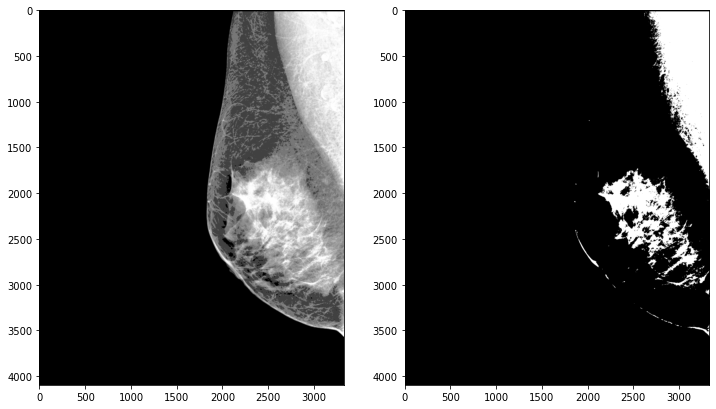

In [ ]:
pect_high_inten_thres = 200
_, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres,
                                     maxval=255, type=cv2.THRESH_BINARY)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(pect_binary_thres, cmap='gray')

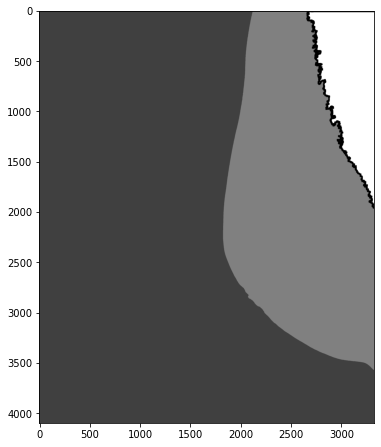

In [ ]:
# Markers image for watershed algo.
pect_marker_img = np.zeros(pect_binary_thres.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(pect_binary_thres, lab_val=255,
                                    fill_holes=True, smooth_boundary=False)
kernel_ = np.ones((3, 3), dtype=np.uint8)
n_erosions = 7
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mammo_breast_mask == 0] = 64
# plot.
fig,ax = plt.subplots()
fig.set_size_inches([6, 9])
ax.imshow(pect_marker_img, cmap='gray')

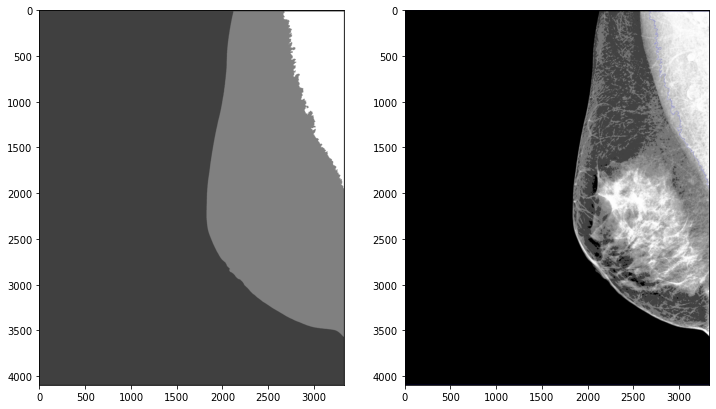

In [ ]:
mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)

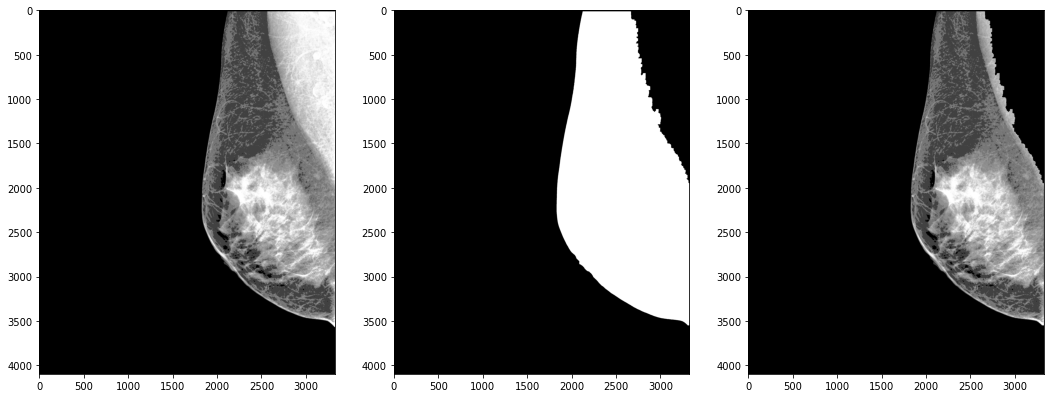

In [ ]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)
fig,axes = plt.subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')

#### Preprocessing class

In [ ]:
if "R_MLO" or "L_MLO" in "06130_20990909_L_CC_5.dcm":
  print(True)
else:
  print(False)

True


In [ ]:
def Remove_pectoral(mammo_med_blurred, median_filtering=True, viewposition='MLO'):

  if median_filtering:
    mammo_med_blurred = cv2.medianBlur(mammo_med_blurred, 3)

  if viewposition=="MLO":

    mammo_breast_mask = select_largest_obj(mammo_med_blurred, lab_val=255,
                                        fill_holes=True,
                                        smooth_boundary=True, kernel_size=15)  # <<= para to tune!


    mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)

    mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)


    pect_high_inten_thres = 200  # <<= para to tune!
    _, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres,
                                      maxval=255, type=cv2.THRESH_BINARY)

    # Markers image for watershed algo.
    pect_marker_img = np.zeros(pect_binary_thres.shape, dtype=np.int32)
    # Sure foreground.
    pect_mask_init = select_largest_obj(pect_binary_thres, lab_val=255,
                                        fill_holes=True, smooth_boundary=False)
    kernel_ = np.ones((3, 3), dtype=np.uint8)  # <<= para to tune!
    n_erosions = 7  # <<= para to tune!
    pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
    pect_marker_img[pect_mask_eroded > 0] = 255
    # Sure background - breast.
    n_dilations = 7  # <<= para to tune!
    pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
    pect_marker_img[pect_mask_dilated == 0] = 128
    # Sure background - background.
    pect_marker_img[mammo_breast_mask == 0] = 64

    mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
    cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
    pect_mask_watershed = pect_marker_img.copy()
    mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
    pect_mask_watershed[pect_mask_watershed == -1] = 0

    breast_only_mask = pect_mask_watershed.astype(np.uint8)
    breast_only_mask[breast_only_mask != 128] = 0
    breast_only_mask[breast_only_mask == 128] = 255
    kn_size = 25  # <<= para to tune!
    kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
    breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
    mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)

    return mammo_breast_only

  else:

    mammo_breast_mask = select_largest_obj(mammo_med_blurred, lab_val=255,
                                        fill_holes=True,
                                        smooth_boundary=True, kernel_size=15)  # <<= para to tune!


    mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)

    mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)

    return mammo_breast_equ

In [ ]:
res= Remove_pectoral(imgp, median_filtering=False)

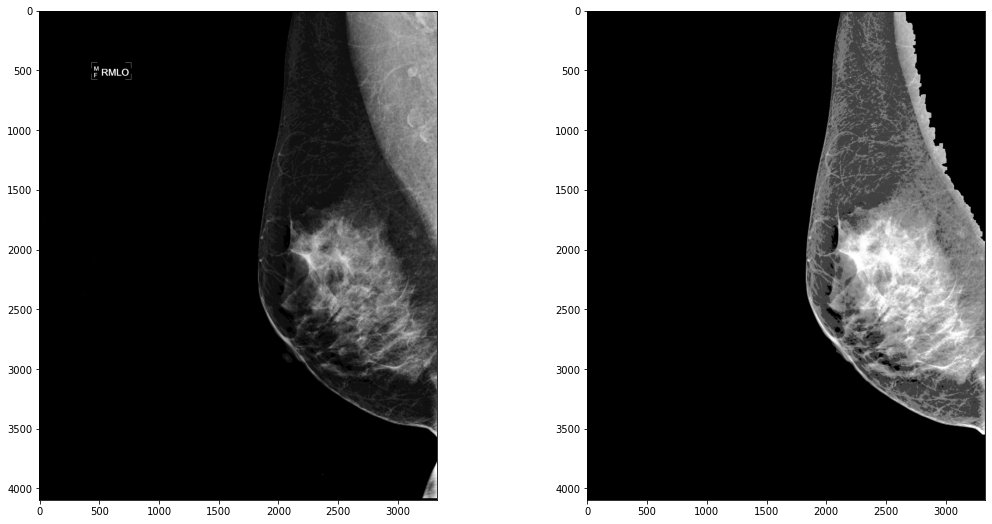

In [ ]:
#%pylab inline
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(res, cmap='gray')
#axes[2].imshow(mammo_col)

In [ ]:
def crop(img):
    """
    Crop ROI from image.
    """

    # Otsu's thresholding after Gaussian filtering
    #blur = cv2.GaussianBlur(img,(5,5),0)
    _, breast_mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY)

    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    return img[y:y+h, x:x+w], breast_mask[y:y+h, x:x+w]

In [ ]:
res_final,_=crop(res)

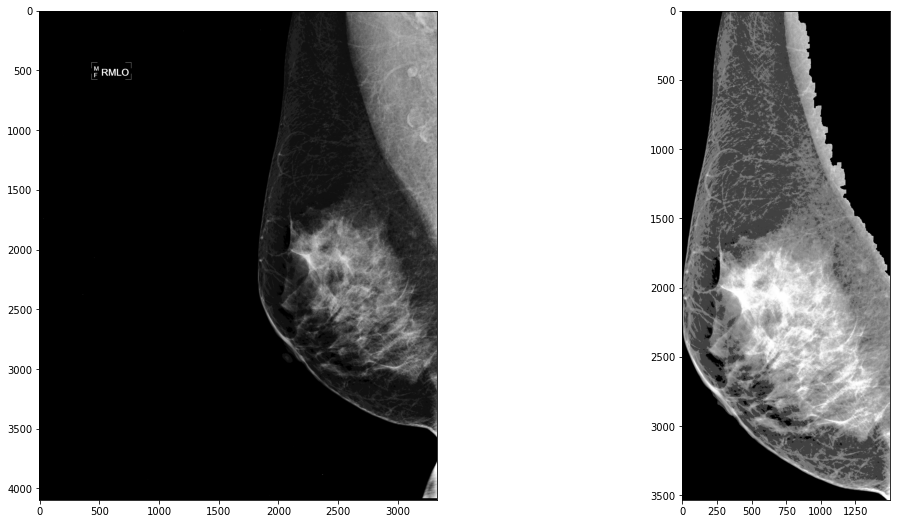

In [ ]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(res_final, cmap='gray')

In [ ]:
def normalize(img):
    lmin = float(img.min())
    lmax = float(img.max())
    return np.floor((img-lmin)/(lmax-lmin)*255.0)

In [ ]:
def truncation_normalization(img):
    """
    Pixel clipped and normalized in breast ROI
    """
    Pmin = np.percentile(img, 5)
    Pmax = np.percentile(img, 99)
    truncated = np.clip(img,Pmin, Pmax)
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    return normalized

In [ ]:
def clahe(img, clip):
    #contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    cl = clahe.apply(np.array(img, dtype=np.uint8))
    return cl

In [ ]:
final=clahe(normalize(res_final),1)
Fito=cv2.merge((final,final,final))

In [ ]:
final.max()

255

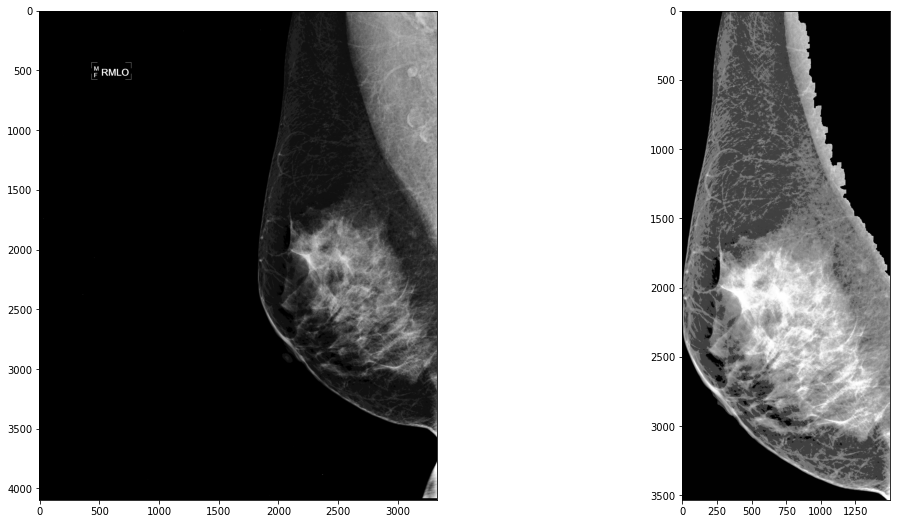

In [ ]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(final, cmap='gray')

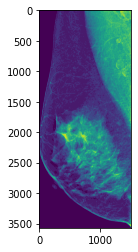

In [ ]:
imgC=cv2.imread("/content/drive/MyDrive/Data_PS3/Image_png/05215_20990909_R_MLO_3.png",0)
plt.imshow(imgC)

In [ ]:
resc= Remove_pectoral(imgC, median_filtering=True)

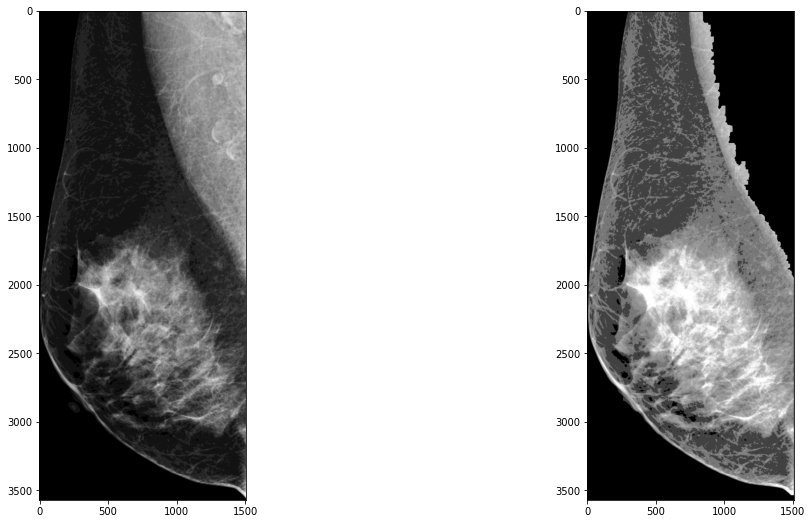

In [ ]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(imgC, cmap='gray')
axes[1].imshow(resc, cmap='gray')

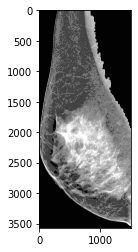

In [ ]:
rcf= clahe(normalize(resc),1)
rgb_img = cv2.cvtColor(rcf, cv2.COLOR_GRAY2RGB)
plt.imshow(rgb_img)

In [ ]:
print(img_name[1])
print(viewpos[1])

06130_20990909_L_MLO_5.dcm
MLO


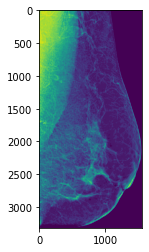

In [ ]:
img0=cv2.imread("/content/drive/MyDrive/Data_PS3/Image_png/06130_20990909_L_MLO_5.png",0)
plt.imshow(img0)

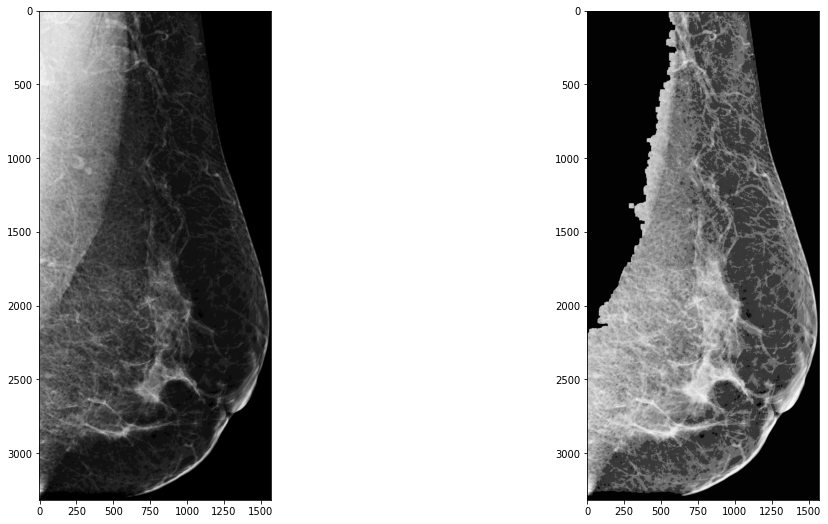

In [ ]:
res0= clahe(normalize(Remove_pectoral(img0, median_filtering=True, viewposition=viewpos[1])),1)
rgb_img = cv2.cvtColor(res0, cv2.COLOR_GRAY2RGB)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(img0, cmap='gray')
axes[1].imshow(rgb_img, cmap='gray')

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Image_png/'

dest_path = "/content/drive/MyDrive/Data_PS3/Image_without_pecto/"

img_name= list(train_df.anon_filename)

for img, view in zip(img_name, viewpos):

  img= img.replace("dcm", "png")
  # Load the DICOM image using pydicom
  image_path = img_path + img

  image = cv2.imread(image_path,0)

  image= Remove_pectoral(image, median_filtering=True, viewposition=view)

  # Convert the NumPy array to a PIL image
  pil_image = Image.fromarray(image)

  dest_file = dest_path + img

  pil_image.save(dest_file)

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Image_png/'

dest_path = "/content/drive/MyDrive/Data_PS3/Image_without_pecto_normalize/"

img_name= list(train_df.anon_filename)

for img, view in zip(img_name, viewpos):

  img= img.replace("dcm", "png")
  # Load the DICOM image using pydicom
  image_path = img_path + img

  image = cv2.imread(image_path,0)

  image= Remove_pectoral(image, median_filtering=True, viewposition=view)

  image= clahe(normalize(image),1)

  # Convert the NumPy array to a PIL image
  pil_image = Image.fromarray(image)

  dest_file = dest_path + img

  pil_image.save(dest_file)

<ipython-input-16-fae8a674f5fe>:4: RuntimeWarning: invalid value encountered in true_divide
  return np.floor((img-lmin)/(lmax-lmin)*255.0)


In [ ]:
img

'08241_20990909_R_CC_1.png'

In [ ]:
img_name[9999]

'08241_20990909_R_CC_1.dcm'

In [ ]:
%pylab inline
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([18, 9])
axes[0].imshow(imgp, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')
#axes[2].imshow(mammo_col)